In [ ]:
from doctest import testsource

import pandas as pd
import numpy as np
import random, copy
import torch
import torch.nn as nn
from torch import no_grad
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, \
    pipeline
from torch.optim import AdamW
from sklearn.metrics import f1_score
from sklearn.utils import resample
import nltk
from nltk.corpus import wordnet, stopwords
from transformers import logging
import matplotlib.pyplot as plt
import os

logging.set_verbosity_error()

# Download NLTK data (WordNet for synonyms, stopwords list)
nltk.download('wordnet')
nltk.download('stopwords')
# Data augmentation: Synonym Replacement
stop_words = set(stopwords.words('english'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

### Load and explore the dataset
We load the data and analyze the distribution of labels, paragraph lengths, and label distributions per keyword and country. We also examine some examples of patronizing paragraphs, especially those with label 4 (highly patronizing).

In [ ]:
df = pd.read_csv('./data/dontpatronizeme_pcl.tsv', sep='\t', header=None,
                 names=["par_id", "art_id", "keyword", "country", "paragraph", "orig_label"], skiprows=4)
df['label'] = df['orig_label'].apply(lambda x: 1 if x >= 2 else 0)

df.info

In [ ]:

# Distribution of original 5 labels (0–4)
label_counts = df["orig_label"].value_counts().sort_index()
print(label_counts)

# Plot distribution
fig, ax = plt.subplots()
label_counts.plot(kind="bar", ax=ax, title="Label Distribution (0-4)")
ax.set_xlabel("Label")
ax.set_ylabel("Count")

for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        xy=(p.get_x() + p.get_width() / 2., p.get_height()),
        xytext=(0, 3),
        textcoords="offset points",
        ha='center', va='bottom'
    )

plt.show()

# Convert to binary (0,1), i.e. labels >=2 are PCL
binary_counts = df["label"].value_counts()
print("Binary distribution:\n", binary_counts)

In [ ]:
df["str_paragraph"] = df["paragraph"].astype(str).fillna("")

df["para_length"] = df["str_paragraph"].apply(lambda x: len(x.split()))
# Group by label, compute mean or median paragraph length
length_by_label = df.groupby("orig_label")["para_length"].mean()
print("Average paragraph length by label:\n", length_by_label)

import seaborn as sns

sns.boxplot(x="orig_label", y="para_length", data=df)
plt.title("Paragraph Length Distribution by Label")
plt.show()


In [ ]:
pd.crosstab(df["keyword"], df["orig_label"]).plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Label distribution per keyword")
plt.ylabel("Count")
plt.show()

pd.crosstab(df["country"], df["orig_label"]).plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Label distribution per country")
plt.ylabel("Count")
plt.show()

In [ ]:
import random

for lbl in [0, 1, 2, 3, 4]:
    subset = df[df["orig_label"] == lbl]
    example = subset.sample(1, random_state=10)
    print(f"\nLabel {lbl} example:")
    print(example["paragraph"].values[0], "\n")

# Note: The data was annotated by multiple annotators (leading to 0–4 labels). Observing paragraphs with label=1 or label=2 often reveals partial disagreements or borderline cases.
# Examine paragraphs that were assigned label 4 (highly patronizing). Are they obviously condescending or do they also have borderline tones?


The result shows that the data set is highly imbalanced, with the majority of paragraphs labeled as 0 (not patronizing) and only a small fraction labeled as 1 (patronizing). The average paragraph length is similar across labels.

### Data Augmentation and Balancing
We will augment the training data by applying two techniques: synonym replacement and back-translation. Synonym replacement replaces words in the text with synonyms, while back-translation translates the text to another language and back to the original language. These techniques can help improve model generalization and robustness.

In [ ]:
# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    # Identify candidate words (non-stopwords, alphabetic only)
    candidates = [i for i, w in enumerate(words) if w.lower() not in stop_words and w.isalpha()]
    random.shuffle(candidates)
    replaced = 0
    for idx in candidates:
        if replaced >= n:
            break
        synonyms = set()
        for syn in wordnet.synsets(words[idx]):
            for lemma in syn.lemmas():
                if lemma.name().lower() != words[idx].lower():
                    synonyms.add(lemma.name().replace('_', ' '))
        if synonyms:
            new_words[idx] = random.choice(list(synonyms))
            replaced += 1
    return " ".join(new_words)


translator_en_to_es = pipeline("translation_en_to_es", model="Helsinki-NLP/opus-mt-en-es", device=-1)
translator_es_to_en = pipeline("translation_es_to_en", model="Helsinki-NLP/opus-mt-es-en", device=-1)


def back_translate(sentence):
    try:
        es_text = translator_en_to_es(sentence, max_length=MAX_LENGTH)[0]['translation_text']
        back_text = translator_es_to_en(es_text, max_length=MAX_LENGTH)[0]['translation_text']
        return back_text
    except Exception as e:
        return sentence  # fallback to original if translation fails


# Augment training data (apply to minority class samples)
def augment_data(df):
    augmented_texts = []
    augmented_labels = []
    for _, row in df[df['label'] == 1].iterrows():
        text = row['paragraph']
        # Synonym replacement augmentation
        aug_text1 = synonym_replacement(text, n=1)
        # Back-translation augmentation
        aug_text2 = back_translate(text)
        augmented_texts.extend([aug_text1, aug_text2])
        augmented_labels.extend([1, 1])
    aug_df = pd.DataFrame({'paragraph': augmented_texts, 'label': augmented_labels})
    # Combine augmented samples with original data
    return pd.concat([df, aug_df], ignore_index=True)


# Oversample minority class to balance the dataset
def oversample_data(df):
    df_majority = df[df['label'] == 0]
    df_minority = df[df['label'] == 1]
    if len(df_minority) == 0 or len(df_majority) == 0:
        return df
    if len(df_minority) < len(df_majority):
        df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=0)
        df_balanced = pd.concat([df_majority, df_minority_upsampled], ignore_index=True)
    else:
        df_majority_upsampled = resample(df_majority, replace=True, n_samples=len(df_minority), random_state=0)
        df_balanced = pd.concat([df_minority, df_majority_upsampled], ignore_index=True)
    # Shuffle after oversampling
    df_balanced = df_balanced.sample(frac=1, random_state=0).reset_index(drop=True)
    return df_balanced

In [ ]:
from sklearn.model_selection import train_test_split

training_dev_df = pd.read_csv('./data/train_semeval_parids-labels.csv', sep=',', header=None,
                              names=["par_id", "values"], skiprows=1)
test_dev_df = pd.read_csv('./data/dev_semeval_parids-labels.csv', sep=',', header=None,
                          names=["par_id", "values"], skiprows=1)

train_dev_index = training_dev_df['par_id']
test_dev_index = test_dev_df['par_id']
df_indexed = df.set_index('par_id', drop=False)

# Then slice with .loc, using your dev-index lists:
train_dev_df = df_indexed.loc[train_dev_index].copy()
test_df = df_indexed.loc[test_dev_index].copy()
train_df, val_df = train_test_split(train_dev_df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
# dev.txt dataset
test_df = test_df.reset_index(drop=True)
test_df.fillna("", inplace=True)

print(train_df.head())
print(train_df.info())
print(test_df.head())
print(test_df.info())

In [ ]:
train_df = train_df.dropna(subset=['paragraph'])
train_df['paragraph'] = train_df['paragraph'].astype(str)

# Augment and balance training data
train_df_aug = augment_data(train_df)
train_df_upsample = oversample_data(train_df)
train_df_both = oversample_data(train_df_aug)

for idx, row in train_df.iterrows():
    if not isinstance(row['paragraph'], str):
        print(f"Row {idx} has invalid type: {type(row['paragraph'])}, value = {row['paragraph']}")

train_df.to_csv("./example_training_data/train.csv", index=False)
train_df_both.to_csv("./example_training_data/train_augmented_oversampled.csv", index=False)
train_df_aug.to_csv("./example_training_data/train_augmented.csv", index=False)
train_df_upsample.to_csv("./example_training_data/train_oversampled.csv", index=False)

val_df.to_csv("./example_training_data/val.csv", index=False)
test_df.to_csv("./example_training_data/test.csv", index=False)


In [ ]:
# Distribution of original 5 labels (0–4)
label_counts = train_df_both["label"].value_counts().sort_index()
print(label_counts)

# Plot distribution
label_counts.plot(kind="bar", title="Train set Label Distribution (0-1)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Distribution of original 5 labels (0–4)
label_counts = test_df["label"].value_counts().sort_index()
print(label_counts)

# Plot distribution
label_counts.plot(kind="bar", title="Test set Label Distribution (0-1)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Training and Evaluation



In [ ]:
MODEL_NAME = 'roberta-base'
MAX_LENGTH = 256
BATCH_SIZE = 16
NUM_EPOCHS = 3
PATIENCE = [2, 3, 4]
WARMUP_PROPORTION = [0.05, 0.1, 0.2]
LR_CANDIDATES = [1e-5, 2e-5, 5e-5]
ENSEMBLE_SEEDS = [42, 52, 62]

In [ ]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed,
)
from transformers.modeling_outputs import SequenceClassifierOutput
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score
import optuna

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.texts = df["paragraph"].tolist()
        self.labels = df["label"].tolist() if "label" in df.columns else None
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        # Tokenize
        inputs = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        )
        # Flatten tensor dims from (1, ...) to (...):
        item = {k: v.squeeze(0) for k, v in inputs.items()}

        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [ ]:
from transformers import RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput


class WeightedRoberta(nn.Module):
    def __init__(self, model_name: str, num_labels: int, class_weights: torch.Tensor):
        super().__init__()
        self.base_model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )
        self.class_weights = class_weights

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            labels=None,
            **kwargs
    ):
        # --- FIX: pop any extra kwarg(s) Trainer might pass ---
        kwargs.pop("num_items_in_batch", None)  # ignore if present

        # Optionally pop other possible stray kwargs here:
        # kwargs.pop("some_other_arg", None)

        # Now run forward without unexpected kwargs
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=None,  # We'll handle the loss below
            **kwargs
        )
        logits = outputs.logits

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
train_labels = train_df['label'].values
class_weights_experiment = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_tensor_experiment = torch.tensor(class_weights_experiment, dtype=torch.float)

train_labels_aug = train_df_aug['label'].values
class_weights_final = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_aug),
    y=train_labels_aug
)
class_weights_tensor_final = torch.tensor(class_weights_final, dtype=torch.float)

print("Experiment class weights:", class_weights_tensor_experiment)
print("Final class weights:", class_weights_tensor_final)

In [ ]:
# ---------------------------------------------
# (E) Create datasets for Trainer
# ---------------------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset = CustomDataset(train_df_both, tokenizer, max_length=MAX_LENGTH)
val_dataset = CustomDataset(val_df, tokenizer, max_length=MAX_LENGTH)
test_dataset = CustomDataset(test_df, tokenizer, max_length=MAX_LENGTH)


# ---------------------------------------------
# (F) Define metric computation for Trainer
# ---------------------------------------------
def compute_metrics(eval_pred):
    """Compute F1 (binary) and accuracy."""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"f1": f1, "accuracy": acc}


# -----------------------------------------------------------------
# (G) Define Optuna objective function for hyperparameter search
# -----------------------------------------------------------------
def objective(trial):
    """
    Optuna objective that:
      - Picks lr, patience, warmup ratio.
      - Trains model.
      - Returns Val F1 for best epoch (Trainer handles early stopping).
    """
    lr = trial.suggest_categorical("lr", LR_CANDIDATES)
    patience = trial.suggest_categorical("patience", PATIENCE)
    warmup_ratio = trial.suggest_categorical("warmup_ratio", WARMUP_PROPORTION)

    # Create Weighted Roberta
    model = WeightedRoberta(
        model_name=MODEL_NAME,
        num_labels=2,
        class_weights=class_weights_tensor_final
    )

    # Define Trainer args
    training_args = TrainingArguments(
        output_dir=f"./optuna_trial_{trial.number}",
        do_train=True,
        do_eval=True,
        num_train_epochs=NUM_EPOCHS,
        learning_rate=lr,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        weight_decay=1e-2,  # from your custom loop
        evaluation_strategy="epoch",  # Evaluate every epoch
        save_strategy="epoch",  # Save every epoch (so we can load best)
        load_best_model_at_end=True,  # Always load best at the end
        metric_for_best_model="f1",  # Which metric to track
        greater_is_better=True,
        bf16=True,  # Use bf16 precision (if supported)
        warmup_ratio=warmup_ratio,  # Warm-up proportion
        logging_steps=50,  # Adjust as desired
        seed=42,  # Keep some default
    )

    # Build a Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(
            early_stopping_patience=patience,
            early_stopping_threshold=0.0
        )],
    )

    # Train
    trainer.train()

    # Evaluate
    eval_metrics = trainer.evaluate()
    val_f1 = eval_metrics["eval_f1"]

    print(f"Trial {trial.number} - LR={lr}, Patience={patience}, Warmup={warmup_ratio} => Val F1={val_f1:.4f}")

    return val_f1


# -----------------------------------------------------------------
# (H) Run an ensemble of models with different seeds
# -----------------------------------------------------------------
for seed in ENSEMBLE_SEEDS:
    # Fix the seed for reproducibility
    set_seed(seed)

    # Create Optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)  # e.g., run 10 trials for each seed

    # Get best params
    best_lr = study.best_params["lr"]
    best_patience = study.best_params["patience"]
    best_warmup_ratio = study.best_params["warmup_ratio"]
    best_val_f1 = study.best_value

    print(
        f"\n[Seed {seed}] Best LR={best_lr}, Patience={best_patience}, Warmup={best_warmup_ratio}, Val F1={best_val_f1:.4f}")

In [17]:
# Best hyperparams discovered for each seed (after Optuna/manual searching):
BEST_PARAMS = {
    42: {"lr": 5e-05, "patience": 3, "warmup_ratio": 0.05, "best_val_f1": 0.5495},
    52: {"lr": 1e-05, "patience": 3, "warmup_ratio": 0.10, "best_val_f1": 0.5497},
    62: {"lr": 1e-05, "patience": 3, "warmup_ratio": 0.05, "best_val_f1": 0.5494},
}

def train_ensemble(
        MODEL_NAME: str,
        train_dataset,
        val_dataset,
        compute_metrics,
        class_weights_tensor,
        ENSEMBLE_SEEDS=[42, 52, 62],
        BATCH_SIZE=8
):
    ensemble_models = []

    for seed in ENSEMBLE_SEEDS:
        set_seed(seed)
        # Extract best hyperparams:
        best_lr = BEST_PARAMS[seed]["lr"]
        best_patience = BEST_PARAMS[seed]["patience"]
        best_warmup_ratio = BEST_PARAMS[seed]["warmup_ratio"]
        best_val_f1 = BEST_PARAMS[seed]["best_val_f1"]

        print(
            f"\n[Seed {seed}] Using LR={best_lr}, Patience={best_patience}, Warmup={best_warmup_ratio}, Val F1={best_val_f1:.4f}")

        # Create final WeightedRoberta model
        final_model = WeightedRoberta(
            model_name=MODEL_NAME,
            num_labels=2,
            class_weights=class_weights_tensor
        )

        # HF Trainer arguments
        training_args = TrainingArguments(
            output_dir=f"./final_model_seed_{seed}",
            do_train=True,
            do_eval=True,
            num_train_epochs=5,
            learning_rate=best_lr,
            per_device_train_batch_size=BATCH_SIZE,
            per_device_eval_batch_size=BATCH_SIZE,
            weight_decay=1e-2,
            evaluation_strategy="epoch",
            # Save and load the best model at end, using "f1" metric as reference
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True,
            bf16=True,  # using bf16 if supported (training trick)
            warmup_ratio=best_warmup_ratio,  # LR scheduling with linear warmup
            logging_strategy="epoch",  # logs once per epoch -> progress bar w/o frequent dict prints
            logging_steps=999999999,  # effectively disables the frequent step-wise logs
            disable_tqdm=False,  # ensure we do see the progress bar
            seed=seed,
        )

        final_trainer = Trainer(
            model=final_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            callbacks=[
                EarlyStoppingCallback(
                    early_stopping_patience=best_patience,
                    early_stopping_threshold=0.0
                )
            ],
        )

        # Train final model
        final_trainer.train()

        # Save and keep best model
        final_trainer.save_model(f"model_seed_{seed}")
        ensemble_models.append(final_trainer.model)

        print(f"Finished training with seed={seed}, best val F1={best_val_f1:.4f}")
        print("-" * 60)

    return ensemble_models


ensemble_models = train_ensemble(MODEL_NAME, train_dataset, val_dataset, compute_metrics, class_weights_tensor_final,
                                 ENSEMBLE_SEEDS, BATCH_SIZE)




[Seed 42] Using LR=5e-05, Patience=3, Warmup=0.05, Val F1=0.5495


D:\y4_code\NLP_CW\.venv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.288100,0.711691,0.490486,0.856119
2,0.088900,0.943653,0.521173,0.912239
3,0.027500,1.326936,0.490323,0.905672
4,0.010400,1.563491,0.433071,0.914030
5,0.002000,1.568572,0.467925,0.915821


Finished training with seed=42, best val F1=0.5495
------------------------------------------------------------

[Seed 52] Using LR=1e-05, Patience=3, Warmup=0.1, Val F1=0.5497


D:\y4_code\NLP_CW\.venv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.336500,0.551558,0.521472,0.906866
2,0.097800,0.836400,0.525680,0.906269
3,0.037200,1.160748,0.555556,0.918806
4,0.013700,1.261890,0.520900,0.911045
5,0.007000,1.378648,0.524823,0.920000


Finished training with seed=52, best val F1=0.5497
------------------------------------------------------------

[Seed 62] Using LR=1e-05, Patience=3, Warmup=0.05, Val F1=0.5494


D:\y4_code\NLP_CW\.venv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.295600,0.586908,0.540698,0.905672
2,0.100300,1.073499,0.486692,0.919403
3,0.039400,1.126292,0.540881,0.912836
4,0.013900,1.281686,0.532895,0.915224
5,0.008600,1.369618,0.506944,0.915224


Finished training with seed=62, best val F1=0.5494
------------------------------------------------------------


In [18]:
BATCH_SIZE = 16  # for example
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_predictions = []
for model in ensemble_models:
    model.eval()
    model.to(device)

    preds = []
    with torch.no_grad():
        for batch in test_loader:
            # batch is a dict with keys like "input_ids", "attention_mask", etc.
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # forward
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # argmax predictions
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)

    all_predictions.append(preds)

# Convert to array for easier voting
all_predictions = np.array(all_predictions)  # shape: (num_models, num_examples)

# Majority vote
ensemble_preds = []
num_models = len(ensemble_models)
for j in range(all_predictions.shape[1]):
    votes = np.sum(all_predictions[:, j])  # sum of predicted 1s
    # predicted label is 1 if > half the models voted 1
    ensemble_preds.append(1 if votes > num_models / 2 else 0)

test_labels = test_df["label"].values
test_f1 = f1_score(test_labels, ensemble_preds, average="binary")
print(f"Ensemble test F1 = {test_f1:.4f}")

# Save predictions
with open("dev.txt", "w") as f:
    for i, pred in enumerate(ensemble_preds):
        par_id = test_df.iloc[i]["par_id"]
        f.write(f"{pred}\n")

print("Predictions saved to val.txt")

Ensemble test F1 = 0.5753
Predictions saved to val.txt


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

# Suppose test_df has columns:
#  "orig_label"    # in {0,1,2,3,4}
#  "label"         # in {0,1} after you binarized 0..1 => 0, 2..4 => 1, etc.
#  "paragraph"     # text field
#  "keyword"       # e.g. homeless, poor-families, etc.
#  "para_length"   # (optional) number of tokens or words in paragraph
#
# Also suppose you have an array `ensemble_preds` of shape (num_examples,),
# each element is {0 or 1}, the predicted binary label from your ensemble.

# 1) Performance (F1) across each original label (0..4).
#    For each label L in {0,1,2,3,4}, we look at test examples with orig_label = L,
#    and see how well the model predicts the binary label within that subset.
label_f1_scores = {}
unique_labels = sorted(test_df["orig_label"].unique())  # e.g. [0,1,2,3,4]
ensemble_preds = np.array(ensemble_preds)

for lab in unique_labels:
    # Subset the DataFrame
    sub_df = test_df[test_df["orig_label"] == lab]
    if len(sub_df) == 0:
        continue  # skip if no samples of this label

    # Indices in the subset
    sub_indices = sub_df.index
    # True binary labels in subset
    sub_labels = sub_df["label"].values
    # Ensemble predictions (same row order)
    sub_preds = ensemble_preds[sub_indices]

    # Compute F1
    f1 = f1_score(sub_labels, sub_preds, average="binary")
    label_f1_scores[lab] = f1

print("F1 by original label (0..4):")
for lab, f1 in label_f1_scores.items():
    print(f"  Label {lab}: F1={f1:.4f}")

# 2) Performance vs. input text length
#    We'll define some length bins, e.g. [0..50, 51..100, 101..200, >200]
bins = [0, 50, 100, 150, 200, 999]  # big upper bound
labels_for_bins = ["(0..50]", "(51..100]", "(101..150]", "(150..200]", "(>200)"]

test_df["length_bin"] = pd.cut(test_df["para_length"], bins=bins, labels=labels_for_bins)

f1_by_length_bin = {}
for bin_label in labels_for_bins:
    sub_df = test_df[test_df["length_bin"] == bin_label]
    if len(sub_df) == 0:
        continue
    sub_labels = sub_df["label"].values
    sub_preds = ensemble_preds[sub_df.index]
    f1 = f1_score(sub_labels, sub_preds, average="binary")
    f1_by_length_bin[bin_label] = f1

print("\nF1 by paragraph length bin:")
for bin_label, f1 in f1_by_length_bin.items():
    print(f"  {bin_label}: F1={f1:.4f}")

# 3) Performance vs. data categories (e.g. 'keyword')
#    We'll compute F1 for each unique keyword. For instance, 'homeless', 'poor-families', etc.
keyword_f1_scores = {}
unique_keywords = test_df["keyword"].unique()

for kw in unique_keywords:
    sub_df = test_df[test_df["keyword"] == kw]
    if len(sub_df) == 0:
        continue
    sub_labels = sub_df["label"].values
    sub_preds = ensemble_preds[sub_df.index]
    f1 = f1_score(sub_labels, sub_preds, average="binary")
    keyword_f1_scores[kw] = f1

print("\nF1 by keyword category:")
for kw, f1 in keyword_f1_scores.items():
    print(f"  {kw}: F1={f1:.4f}")


F1 by original label (0..4):
  Label 0: F1=0.0000
  Label 1: F1=0.0000
  Label 2: F1=0.2000
  Label 3: F1=0.6094
  Label 4: F1=0.8205


D:\y4_code\NLP_CW\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



F1 by paragraph length bin:
  (0..50]: F1=0.6220
  (51..100]: F1=0.4962
  (101..150]: F1=0.6000
  (150..200]: F1=0.6667
  (>200): F1=0.0000

F1 by keyword category:
  hopeless: F1=0.5200
  refugee: F1=0.5385
  in-need: F1=0.7297
  homeless: F1=0.5862
  poor-families: F1=0.5763
  women: F1=0.3000
  immigrant: F1=0.2500
  migrant: F1=0.5000
  vulnerable: F1=0.6154
  disabled: F1=0.5217


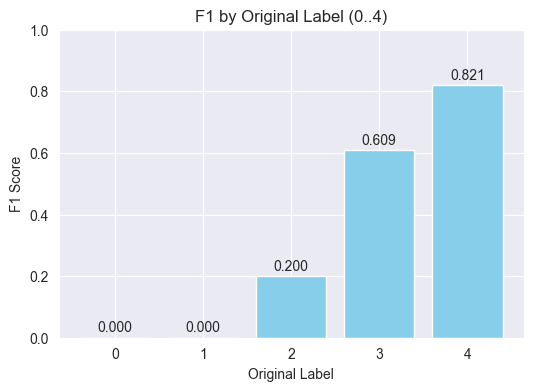

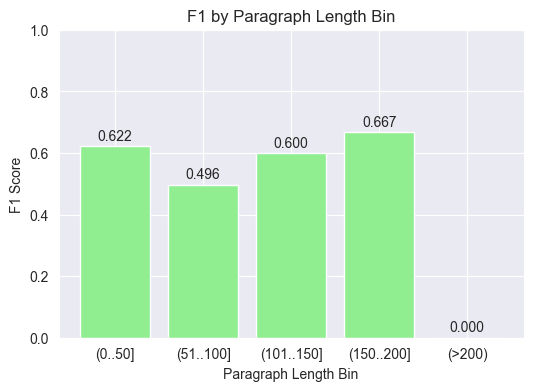

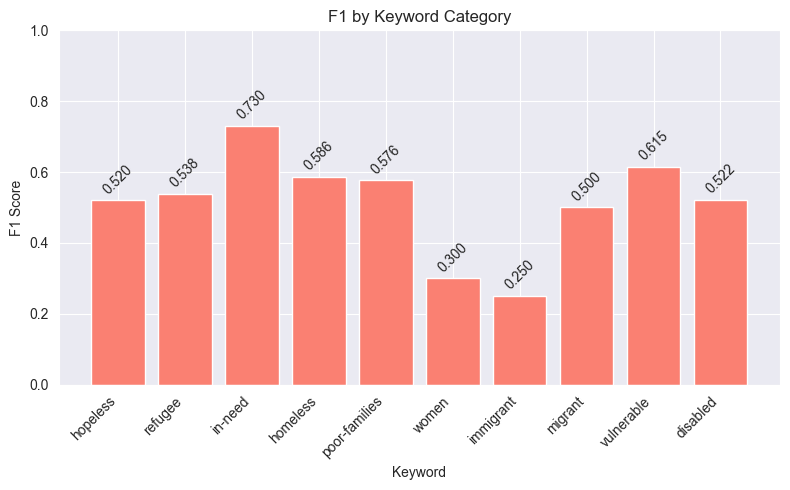

In [20]:
import matplotlib.pyplot as plt


# 1) Plot F1 by original label (0..4)
def plot_f1_by_label(label_f1_scores):
    # label_f1_scores is a dict { label_val: f1, ... }
    labels = list(label_f1_scores.keys())
    f1s = list(label_f1_scores.values())

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar([str(l) for l in labels], f1s, color="skyblue")
    ax.set_title("F1 by Original Label (0..4)")
    ax.set_xlabel("Original Label")
    ax.set_ylabel("F1 Score")
    for i, v in enumerate(f1s):
        ax.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom")
    plt.ylim([0, 1])  # since F1 is between 0..1
    plt.show()


# 2) Plot F1 by paragraph length bin
def plot_f1_by_length_bin(f1_by_length_bin):
    # f1_by_length_bin might be: { "(0..50]": 0.8, "(51..100]":0.76, ... }
    bins = list(f1_by_length_bin.keys())
    f1s = list(f1_by_length_bin.values())

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(bins, f1s, color="lightgreen")
    ax.set_title("F1 by Paragraph Length Bin")
    ax.set_xlabel("Paragraph Length Bin")
    ax.set_ylabel("F1 Score")
    for i, v in enumerate(f1s):
        ax.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom")
    plt.ylim([0, 1])
    plt.show()


# 3) Plot F1 by keyword
def plot_f1_by_keyword(keyword_f1_scores):
    # keyword_f1_scores: { "homeless": 0.7, "poor-families": 0.6, ... }
    keywords = list(keyword_f1_scores.keys())
    f1s = list(keyword_f1_scores.values())

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(keywords, f1s, color="salmon")
    ax.set_title("F1 by Keyword Category")
    ax.set_xlabel("Keyword")
    ax.set_ylabel("F1 Score")
    # rotate x ticks if many categories
    plt.xticks(rotation=45, ha="right")
    for i, v in enumerate(f1s):
        ax.text(i, v + 0.01, f"{v:.3f}", ha="center", va="bottom", rotation=45)
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()


# Finally, call the functions with your dictionaries:
plot_f1_by_label(label_f1_scores)
plot_f1_by_length_bin(f1_by_length_bin)
plot_f1_by_keyword(keyword_f1_scores)


In [21]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# 1) Read test file
final_test_df = pd.read_csv(
    "./data/task4_test.tsv",
    sep="\t",
    header=None,
    names=["par_id", "art_id", "keyword", "country", "paragraph"],
    skiprows=0,
)
print(final_test_df.head())
print(final_test_df.info())

# 2) Drop rows with no paragraph
final_test_df = final_test_df.dropna(subset=["paragraph"])
final_test_df["paragraph"] = final_test_df["paragraph"].astype(str)

# Suppose you have a CustomDataset that expects a DataFrame with "paragraph"
final_dataset = CustomDataset(final_test_df, tokenizer, max_length=MAX_LENGTH)

# 3) DataLoader for test
final_test_loader = DataLoader(final_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_predictions = []
for model in ensemble_models:
    model.eval()
    model.to(device)

    preds = []
    with torch.no_grad():
        for batch in final_test_loader:
            # batch is a dict with keys like "input_ids", "attention_mask", ...
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # argmax predictions
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)

    all_predictions.append(preds)

# Convert to array for easier voting
all_predictions = np.array(all_predictions)  # shape: (num_models, num_examples)

# 4) Majority vote
ensemble_preds = []
num_models = len(ensemble_models)
for j in range(all_predictions.shape[1]):
    votes = np.sum(all_predictions[:, j])  # sum of predicted 1s
    # predicted label is 1 if > half the models voted 1
    ensemble_preds.append(1 if votes > (num_models / 2) else 0)

# 5) Save predictions *with* ID to file
with open("test.txt", "w", encoding="utf-8") as f:
    # final_test_df should have the same row order as final_dataset
    for i, pred in enumerate(ensemble_preds):
        par_id = final_test_df.iloc[i]["par_id"]
        f.write(f"{pred}\n")

print(f"Generated {len(ensemble_preds)} predictions for {len(final_test_df)} test examples.")
print("Saved to test.txt")


  par_id      art_id     keyword country  \
0    t_0   @@7258997  vulnerable      us   
1    t_1  @@16397324       women      pk   
2    t_2  @@16257812     migrant      ca   
3    t_3   @@3509652     migrant      gb   
4    t_4    @@477506  vulnerable      ca   

                                           paragraph  
0  In the meantime , conservatives are working to...  
1  In most poor households with no education chil...  
2  The real question is not whether immigration i...  
3  In total , the country 's immigrant population...  
4  Members of the church , which is part of Ken C...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   par_id     3832 non-null   object
 1   art_id     3832 non-null   object
 2   keyword    3832 non-null   object
 3   country    3832 non-null   object
 4   paragraph  3832 non-null   object
dtypes: object(5)
memory u

In [22]:
import random
import numpy as np
import torch
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.utils import shuffle


###################################################
# REUSABLE UTILITIES (SEEDING, ETC.)
###################################################
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


###################################################
# BOW BASELINE IMPLEMENTATION
###################################################
def train_bow_baseline(train_df, val_df, seed=42):
    """
    Trains a simple Naïve Bayes Bag-of-Words baseline.

    :param train_df: A pandas DataFrame with columns ['paragraph', 'label']
    :param val_df: A pandas DataFrame with columns ['paragraph', 'label']
    :param seed: Random seed for reproducibility
    :return: A tuple (vectorizer, model) of the trained baseline
    """

    # Ensure reproducibility
    set_seed(seed)

    # Shuffle data (optional, but often good practice)
    train_df = shuffle(train_df, random_state=seed).reset_index(drop=True)
    val_df = shuffle(val_df, random_state=seed).reset_index(drop=True)

    # Separate features and labels
    X_train = train_df['paragraph'].tolist()
    y_train = train_df['label'].values
    X_val = val_df['paragraph'].tolist()
    y_val = val_df['label'].values

    # Create a CountVectorizer (Bag-of-Words)
    vectorizer = CountVectorizer(
        lowercase=True,
        stop_words='english',  # optional; can remove if you want exact BOW
        max_features=10000  # limit vocab size if needed
    )

    # Fit vectorizer on training data, then transform both train and val
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    # Define a simple MultinomialNB model
    model = MultinomialNB()

    # Train the model
    model.fit(X_train_vec, y_train)

    # Predict on validation set
    val_preds = model.predict(X_val_vec)
    val_f1 = f1_score(y_val, val_preds, average='binary')

    print(f"[BoW Baseline] Validation F1 = {val_f1:.4f}")

    return vectorizer, model


vec, model = train_bow_baseline(train_df, val_df, seed=42)

with torch.no_grad():
    # Predict on test set
    X_test = test_df['paragraph'].tolist()
    y_test = test_df['label'].values
    X_test_vec = vec.transform(X_test)
    test_preds = model.predict(X_test_vec)
    test_f1 = f1_score(y_test, test_preds, average='binary')

    print(f"[BoW Baseline] Test F1 = {test_f1:.4f}")
# augmented data
vec_aug, model_aug = train_bow_baseline(train_df_aug, val_df, seed=42)

with torch.no_grad():
    # Predict on test set
    X_test = test_df['paragraph'].tolist()
    y_test = test_df['label'].values
    X_test_vec = vec_aug.transform(X_test)
    test_preds = model_aug.predict(X_test_vec)
    test_f1 = f1_score(y_test, test_preds, average='binary')

    print(f"[BoW Augmented Baseline] Test F1 = {test_f1:.4f}")

vec_over, model_over = train_bow_baseline(train_df_upsample, val_df, seed=42)
with torch.no_grad():
    # Predict on test set
    X_test = test_df['paragraph'].tolist()
    y_test = test_df['label'].values
    X_test_vec = vec_over.transform(X_test)
    test_preds = model_over.predict(X_test_vec)
    test_f1 = f1_score(y_test, test_preds, average='binary')

    print(f"[BoW Oversampled Baseline] Test F1 = {test_f1:.4f}")
    one_but_zero = False
    zero_but_one = False
    for i, (true, pred) in enumerate(zip(y_test, test_preds)):
        if not one_but_zero and (true == 1 and pred == 0):
            one_but_zero = True
            print(f"ID: {test_df['par_id'].iloc[i]}")
            print(f"Text: {test_df['paragraph'].iloc[i]}")
            print(f"True label: {true}, Predicted: {pred}")
            print("-" * 50)
        if not zero_but_one and (true == 0 and pred == 1):
            zero_but_one = True
            print(f"ID: {test_df['par_id'].iloc[i]}")
            print(f"Text: {test_df['paragraph'].iloc[i]}")
            print(f"True label: {true}, Predicted: {pred}")
            print("-" * 50)
        if one_but_zero and zero_but_one:
            break

[BoW Baseline] Validation F1 = 0.3059
[BoW Baseline] Test F1 = 0.2587
[BoW Baseline] Validation F1 = 0.4040
[BoW Augmented Baseline] Test F1 = 0.3359
[BoW Baseline] Validation F1 = 0.3964
[BoW Oversampled Baseline] Test F1 = 0.3394
ID: 4046
Text: We also know that they can benefit by receiving counseling from someone who can help them understand that their feelings are normal and that their situation is not hopeless ; someone who can help them put their situation in perspective and help them communicate with others who could provide support ; someone knowledgeable about resources they can access ; someone who can help them plan for their needs and the needs of their child by developing either a parenting plan or an adoption plan .
True label: 1, Predicted: 0
--------------------------------------------------
ID: 8391
Text: Marcos said the government should help poor families that try every possible means to survive . With Joel Zurbano <h> More from this Category :
True label: 0, Predic

In [23]:
import random
import numpy as np
import torch
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils import shuffle


###################################################
# TF–IDF + LOGISTIC REGRESSION BASELINE
###################################################
def train_lr_tfidf_baseline(train_df, val_df, seed=42):
    """
    Trains a simple Logistic Regression baseline with TF–IDF features.

    :param train_df: A pandas DataFrame with columns ['paragraph', 'label']
    :param val_df:   A pandas DataFrame with columns ['paragraph', 'label']
    :param seed:     Random seed for reproducibility
    :return: A tuple (vectorizer, model) of the trained baseline
    """

    # Ensure reproducibility
    set_seed(seed)

    # Shuffle data (optional)
    train_df = shuffle(train_df, random_state=seed).reset_index(drop=True)
    val_df = shuffle(val_df, random_state=seed).reset_index(drop=True)

    # Separate features and labels
    X_train = train_df['paragraph'].tolist()
    y_train = train_df['label'].values
    X_val = val_df['paragraph'].tolist()
    y_val = val_df['label'].values

    # Create a TfidfVectorizer
    vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words='english',  # Remove common English stopwords
        max_features=10000  # Limit vocab size if needed
    )

    # Fit TF-IDF on training data, then transform both train and val
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    # Define Logistic Regression model
    model = LogisticRegression(
        penalty='l2',
        C=1.0,  # Regularization strength
        class_weight=None,  # or 'balanced' if needed for imbalanced data
        random_state=seed,
        max_iter=200  # Increase if you encounter convergence warnings
    )

    # Train (fit) the model
    model.fit(X_train_vec, y_train)

    # Predict on validation set
    val_preds = model.predict(X_val_vec)
    val_f1 = f1_score(y_val, val_preds, average='binary')

    print(f"[LR+TF–IDF Baseline] Validation F1 = {val_f1:.4f}")

    return vectorizer, model


vec, model = train_lr_tfidf_baseline(train_df, val_df, seed=42)

with torch.no_grad():
    # Predict on test set
    X_test = test_df['paragraph'].tolist()
    y_test = test_df['label'].values
    X_test_vec = vec.transform(X_test)
    test_preds = model.predict(X_test_vec)
    test_f1 = f1_score(y_test, test_preds, average='binary')

    print(f"[LR+TF–IDF Baseline] Test F1 = {test_f1:.4f}")
# augmented data
vec_aug, model_aug = train_lr_tfidf_baseline(train_df_aug, val_df, seed=42)

with torch.no_grad():
    # Predict on test set
    X_test = test_df['paragraph'].tolist()
    y_test = test_df['label'].values
    X_test_vec = vec_aug.transform(X_test)
    test_preds = model_aug.predict(X_test_vec)
    test_f1 = f1_score(y_test, test_preds, average='binary')

    print(f"[LR+TF–IDF Augmented Baseline] Test F1 = {test_f1:.4f}")

vec_over, model_over = train_lr_tfidf_baseline(train_df_upsample, val_df, seed=42)

with torch.no_grad():
    # Predict on test set
    X_test = test_df['paragraph'].tolist()
    y_test = test_df['label'].values
    X_test_vec = vec_over.transform(X_test)
    test_preds = model_over.predict(X_test_vec)
    test_f1 = f1_score(y_test, test_preds, average='binary')

    print(f"[LR+TF–IDF Oversampled Baseline] Test F1 = {test_f1:.4f}")

    one_but_zero = False
    zero_but_one = False
    for i, (true, pred) in enumerate(zip(y_test, test_preds)):
        if not one_but_zero and (true == 1 and pred == 0):
            one_but_zero = True
            print(f"ID: {test_df['par_id'].iloc[i]}")
            print(f"Text: {test_df['paragraph'].iloc[i]}")
            print(f"True label: {true}, Predicted: {pred}")
            print("-" * 50)
        if not zero_but_one and (true == 0 and pred == 1):
            zero_but_one = True
            print(f"ID: {test_df['par_id'].iloc[i]}")
            print(f"Text: {test_df['paragraph'].iloc[i]}")
            print(f"True label: {true}, Predicted: {pred}")
            print("-" * 50)
        if one_but_zero and zero_but_one:
            break

[LR+TF–IDF Baseline] Validation F1 = 0.0000
[LR+TF–IDF Baseline] Test F1 = 0.0197
[LR+TF–IDF Baseline] Validation F1 = 0.3056
[LR+TF–IDF Augmented Baseline] Test F1 = 0.2500
[LR+TF–IDF Baseline] Validation F1 = 0.4451
[LR+TF–IDF Oversampled Baseline] Test F1 = 0.3697
ID: 4089
Text: In a 90-degree view of his constituency , one can see a high rise and a flyover while underneath it , homeless people sleep on pavements . " As you can see , my constituency is not confined to one socio-economic group , " he said , adding that apart from water , another major concern for him is to improve the standard of public schools in the area .
True label: 1, Predicted: 0
--------------------------------------------------
ID: 8391
Text: Marcos said the government should help poor families that try every possible means to survive . With Joel Zurbano <h> More from this Category :
True label: 0, Predicted: 1
--------------------------------------------------


In [24]:
import torch
import torch.nn as nn
import copy
import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import f1_score
from transformers import (
    AutoModelForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup,
    AutoTokenizer
)
from torch.utils.data import DataLoader, TensorDataset
import torch.cuda.amp

# --------------------------------------------------------------
# Configuration / constants
# --------------------------------------------------------------
MODEL_NAME = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 16
NUM_EPOCHS = 3
PATIENCE = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# You can set a fixed seed for reproducibility if you like
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# --------------------------------------------------------------
# 1) Data Preparation: build_dataloader
# --------------------------------------------------------------
def build_dataloader(df, tokenizer, batch_size=BATCH_SIZE, shuffle=False):
    """
    Given a DataFrame with a 'paragraph' column and optional 'label' column,
    build a PyTorch DataLoader.
    """
    texts = list(df['paragraph'])
    encodings = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    if 'label' in df.columns:
        labels = torch.tensor(df['label'].values, dtype=torch.long)
        dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)
    else:
        dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])

    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=True)


# --------------------------------------------------------------
# 2) Training Function
# --------------------------------------------------------------
def train_model(
    train_loader,
    val_loader,
    learning_rate,
    class_weights_tensor=None,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    use_scheduler=True,
    seed=42,
    warm_up=0.1
):
    """
    Train a binary classification model with optional
    - Weighted loss
    - Linear schedule (warmup + decay) toggled by use_scheduler.

    Returns:
        - best_model (with best validation F1),
        - best_val_f1
    """
    set_seed(seed)

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    model.to(device)

    # Optimizer
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)

    # Scheduler (optionally)
    if use_scheduler:
        total_steps = num_epochs * len(train_loader)
        warmup_steps = int(warm_up * total_steps)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
    else:
        scheduler = None

    # Automatic Mixed Precision scaler
    scaler = torch.cuda.amp.GradScaler()

    best_f1 = 0.0
    best_state = None
    epochs_no_improve = 0

    for epoch in tqdm(range(1, num_epochs + 1), desc="Epoch", leave=False):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            # Forward pass (using bf16 precision)
            with torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                if class_weights_tensor is not None:
                    loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
                else:
                    loss_fct = nn.CrossEntropyLoss()

                loss = loss_fct(logits, labels)

            # Backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if scheduler is not None:
                scheduler.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_f1 = f1_score(all_labels, all_preds, average='binary')
        print(f"Epoch {epoch}/{num_epochs} - Loss: {total_loss / len(train_loader):.4f} - Val F1: {val_f1:.4f}")

        # Early stopping check
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Load best state
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_f1


# --------------------------------------------------------------
# 3) Testing (Evaluation) Function
# --------------------------------------------------------------
def test_model(model, test_loader):
    """
    Compute F1 score on the test set using a trained model.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return f1_score(all_labels, all_preds, average='binary')


# --------------------------------------------------------------
# 4) Example Class Weights Calculation (if needed)
# --------------------------------------------------------------
def compute_class_weights(df):
    """
    Compute simple class weights for a binary classification problem:
    weight_i = total_samples / (num_classes * count_of_class_i).
    """
    # Only works if 'label' is 0 or 1
    label_counts = df['label'].value_counts()
    num_classes = 2
    total_samples = len(df)
    weights = []
    for class_idx in range(num_classes):
        count = label_counts[class_idx] if class_idx in label_counts else 1
        weight_i = total_samples / (num_classes * count)
        weights.append(weight_i)
    return torch.tensor(weights, dtype=torch.float)


# --------------------------------------------------------------
# 5) Running the Experiments
# --------------------------------------------------------------
# Let's say we have the following DataFrames in memory:
#   train_df, train_df_aug, train_df_upsample, train_df_both, val_df, test_df
# They already contain columns: ['paragraph', 'label'].

# 5.1 Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 5.2 Build loaders for val and test from the "original" (shared) data
val_loader = build_dataloader(val_df, tokenizer, batch_size=BATCH_SIZE, shuffle=False)
test_loader = build_dataloader(test_df, tokenizer, batch_size=BATCH_SIZE, shuffle=False)

# 5.3 We'll define six experiments:
#    1) Only Data Augmentation, NO scheduler
#    2) Only Data Augmentation, WITH scheduler
#    3) Only Upsampling, NO scheduler
#    4) Only Upsampling, WITH scheduler
#    5) Only Weighted Loss, NO scheduler
#    6) Only Weighted Loss, WITH scheduler

experiments = []
experiments.append({
    "name": "Augmentation_Only_NoSched",
    "train_df": train_df_aug,
    "use_scheduler": False,
    "use_weights": False
})
experiments.append({
    "name": "Augmentation_Only_Sched",
    "train_df": train_df_aug,
    "use_scheduler": True,
    "use_weights": False
})
experiments.append({
    "name": "Upsample_Only_NoSched",
    "train_df": train_df_upsample,
    "use_scheduler": False,
    "use_weights": False
})
experiments.append({
    "name": "Upsample_Only_Sched",
    "train_df": train_df_upsample,
    "use_scheduler": True,
    "use_weights": False
})
experiments.append({
    "name": "WeightedLoss_Only_NoSched",
    "train_df": train_df,  # original data
    "use_scheduler": False,
    "use_weights": True
})
experiments.append({
    "name": "WeightedLoss_Only_Sched",
    "train_df": train_df,  # original data
    "use_scheduler": True,
    "use_weights": True
})

results = []

for exp in experiments:
    print("================================================")
    print(f"Starting Experiment: {exp['name']}")

    # --- Build train loader ---
    train_loader = build_dataloader(
        exp["train_df"],
        tokenizer,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # --- Compute optional class weights ---
    if exp["use_weights"]:
        class_weights_tensor = compute_class_weights(exp["train_df"])
    else:
        class_weights_tensor = None

    # --- Train ---
    model, best_val_f1 = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        learning_rate=2e-5,              # (Ignoring hyperparam tuning, just pick a standard LR)
        class_weights_tensor=class_weights_tensor,
        num_epochs=NUM_EPOCHS,
        patience=PATIENCE,
        use_scheduler=exp["use_scheduler"],
        seed=42
    )

    # --- Test ---
    test_f1 = test_model(model, test_loader)

    print(f"Experiment {exp['name']} complete.")
    print(f"Best Validation F1 = {best_val_f1:.4f}")
    print(f"Test F1 = {test_f1:.4f}")

    results.append({
        "Experiment": exp["name"],
        "Val_F1": best_val_f1,
        "Test_F1": test_f1
    })


# --------------------------------------------------------------
# 6) Summarize Results
# --------------------------------------------------------------
print("\n\n===== Experiment Results =====")
for r in results:
    print(f"{r['Experiment']}: Val F1={r['Val_F1']:.4f}, Test F1={r['Test_F1']:.4f}")

Starting Experiment: Augmentation_Only_NoSched


D:\y4_code\NLP_CW\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\24983\AppData\Local\Temp\ipykernel_13656\627586888.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 0.3275 - Val F1: 0.4848


Epoch:  33%|███▎      | 1/3 [01:14<02:29, 74.98s/it]

Epoch 2/3 - Loss: 0.0804 - Val F1: 0.4834


Epoch:  67%|██████▋   | 2/3 [02:28<01:14, 74.12s/it]

Epoch 3/3 - Loss: 0.0307 - Val F1: 0.4646
Early stopping triggered.


Experiment Augmentation_Only_NoSched complete.
Best Validation F1 = 0.4848
Test F1 = 0.5596
Starting Experiment: Augmentation_Only_Sched


D:\y4_code\NLP_CW\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\24983\AppData\Local\Temp\ipykernel_13656\627586888.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 0.3862 - Val F1: 0.4886


Epoch:  33%|███▎      | 1/3 [01:13<02:27, 73.91s/it]

Epoch 2/3 - Loss: 0.1115 - Val F1: 0.5227


Epoch:  67%|██████▋   | 2/3 [02:27<01:13, 73.94s/it]

Epoch 3/3 - Loss: 0.0241 - Val F1: 0.4815


Experiment Augmentation_Only_Sched complete.
Best Validation F1 = 0.5227
Test F1 = 0.5484
Starting Experiment: Upsample_Only_NoSched


D:\y4_code\NLP_CW\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\24983\AppData\Local\Temp\ipykernel_13656\627586888.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 0.2434 - Val F1: 0.5017


Epoch:  33%|███▎      | 1/3 [01:46<03:32, 106.08s/it]

Epoch 2/3 - Loss: 0.0445 - Val F1: 0.4945


Epoch:  67%|██████▋   | 2/3 [03:33<01:46, 106.68s/it]

Epoch 3/3 - Loss: 0.0197 - Val F1: 0.5203


Experiment Upsample_Only_NoSched complete.
Best Validation F1 = 0.5203
Test F1 = 0.5444
Starting Experiment: Upsample_Only_Sched


D:\y4_code\NLP_CW\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\24983\AppData\Local\Temp\ipykernel_13656\627586888.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 0.3180 - Val F1: 0.5155


Epoch:  33%|███▎      | 1/3 [01:47<03:35, 107.99s/it]

Epoch 2/3 - Loss: 0.0430 - Val F1: 0.4789


Epoch:  67%|██████▋   | 2/3 [03:34<01:47, 107.41s/it]

Epoch 3/3 - Loss: 0.0083 - Val F1: 0.4684
Early stopping triggered.


Experiment Upsample_Only_Sched complete.
Best Validation F1 = 0.5155
Test F1 = 0.5266
Starting Experiment: WeightedLoss_Only_NoSched


D:\y4_code\NLP_CW\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\24983\AppData\Local\Temp\ipykernel_13656\627586888.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 0.5344 - Val F1: 0.4576


Epoch:  33%|███▎      | 1/3 [01:05<02:10, 65.41s/it]

Epoch 2/3 - Loss: 0.3340 - Val F1: 0.5323


Epoch:  67%|██████▋   | 2/3 [02:11<01:05, 65.99s/it]

Epoch 3/3 - Loss: 0.1648 - Val F1: 0.5155


Experiment WeightedLoss_Only_NoSched complete.
Best Validation F1 = 0.5323
Test F1 = 0.5500
Starting Experiment: WeightedLoss_Only_Sched


D:\y4_code\NLP_CW\.venv\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\24983\AppData\Local\Temp\ipykernel_13656\627586888.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 0.5548 - Val F1: 0.4721


Epoch:  33%|███▎      | 1/3 [01:06<02:12, 66.40s/it]

Epoch 2/3 - Loss: 0.3133 - Val F1: 0.5285


Epoch:  67%|██████▋   | 2/3 [02:13<01:06, 66.54s/it]

Epoch 3/3 - Loss: 0.1342 - Val F1: 0.5524


Experiment WeightedLoss_Only_Sched complete.
Best Validation F1 = 0.5524
Test F1 = 0.5524


===== Experiment Results =====
Augmentation_Only_NoSched: Val F1=0.4848, Test F1=0.5596
Augmentation_Only_Sched: Val F1=0.5227, Test F1=0.5484
Upsample_Only_NoSched: Val F1=0.5203, Test F1=0.5444
Upsample_Only_Sched: Val F1=0.5155, Test F1=0.5266
WeightedLoss_Only_NoSched: Val F1=0.5323, Test F1=0.5500
WeightedLoss_Only_Sched: Val F1=0.5524, Test F1=0.5524
